In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchtext.data import Field, TabularDataset, BucketIterator 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mikatsuki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here we import needed packages.

# 4.3.1 Dataset and Dataloader

read the training data, split it into train set and validation set, store them in csv file

In [3]:
def prepare_dataset(PATH):
    #test_df = pd.read_csv(PATH+'test.csv', sep=',')
    train_df = pd.read_csv(PATH+'train.csv', sep=',')
    train_c0_df = train_df.loc[train_df['label']==0]
    train_c1_df = train_df.loc[train_df['label']==1]
    train_c0_df, val_c0_df = train_test_split(train_c0_df, test_size = 1000, random_state=4211)
    train_c1_df, val_c1_df = train_test_split(train_c1_df, test_size = 1000, random_state=4211)
    
    train_df = train_c0_df.append(train_c1_df)
    val_df = val_c0_df.append(val_c1_df)
    train_df.to_csv(PATH+'ntrain.csv', index=False)
    val_df.to_csv(PATH+'valid.csv', index=False)

In [4]:
PATH='D:/ust courses/comp4211/pa3/' #path is the direction of data, should set before running
batch_size = 64
prepare_dataset(PATH = PATH)
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) # "i like the moive" -> "i", "like", "the", "movie"
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
train, valid, test=TabularDataset.splits(path=PATH, train='ntrain.csv', validation='valid.csv', test='test.csv', format='csv', fields=[('label', label_field), ('text', txt_field)], skip_header=True)
txt_field.build_vocab(train, min_freq=0)
all_word = len(txt_field.vocab)
txt_field.build_vocab(train, min_freq=2)
print('OOV of training set: {}'.format(all_word-len(txt_field.vocab)))

train_iter, valid_iter, test_iter = BucketIterator.splits((train, valid, test), batch_size=batch_size, sort_key=lambda x: len(x.text),sort_within_batch=True)
batch = next(iter(train_iter))
sent, sent_len = batch.text

C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further informa

OOV of training set: 8650


C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Here output the Q1 answer.

# 4.3.2 RNN Baseline Model

Define the baseline model first.

In [19]:
class rnn_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=False)
        self.linear = nn.Linear(64,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [22]:
from torchsummaryX import summary

model = rnn_model(len(txt_field.vocab), 50, 64, 1, 0.1).cuda()
summary(model, torch.zeros((64,20), dtype=torch.int64).cuda(), torch.zeros(64, dtype=torch.int64).cuda())

          Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                  
0_emb       [50, 7953]  [64, 20, 50]  397.65k   397.65k
1_rnn                -  [64, 20, 64]   7.424k    7.296k
2_linear       [64, 1]   [64, 20, 1]     65.0      64.0
3_sigmoid            -   [64, 20, 1]        -         -
---------------------------------------------------------
                        Totals
Total params          405.139k
Trainable params      405.139k
Non-trainable params       0.0
Mult-Adds              405.01k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_emb,"[50, 7953]","[64, 20, 50]",397650.0,397650.0
1_rnn,-,"[64, 20, 64]",7424.0,7296.0
2_linear,"[64, 1]","[64, 20, 1]",65.0,64.0
3_sigmoid,-,"[64, 20, 1]",NaN,NaN


create a function for calculating the total trainable parameters.

In [6]:
def get_total_trainable_para():
    model = rnn_model(len(txt_field.vocab), 50, 64, 1, 0.1).cuda()
    total_p = 0
    for p_l in list(model.parameters()):
        n_para = 1
        for n in p_l.size():
            n_para *= n
        total_p += n_para
    return total_p
print('the total trainable parameters: {}'.format(get_total_trainable_para()))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


the total trainable parameters: 405139


Here outptu the Q2 answer.

Then, create function for save and load checkpoint.

In [7]:
def save_checkpoint(save_path, model, optimizer, val_loss, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss,
                  'val_acc':val_acc}

    torch.save(state_dict, PATH+save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(PATH+save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    val_acc = state_dict['val_acc']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}, and val acc: {val_acc}')
    return val_loss, val_acc

contructe the training funciton to train the model and get the loss value

In [8]:
def TRAIN(model, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_acc, device, save_name):
    f = open(PATH+save_name+'_record.txt', 'w')
    
    record_train=[]
    record_val=[]
    
    if val_acc==0:
        best_val_acc = 0  
    else: 
        best_val_acc=val_acc
        print('Resume training')
    
    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        begin = time.time()
        model.train()
        running_loss = 0.0
        for i, text_info in enumerate(train_loader):

            labels = text_info.label.float().to(device)
            labels = labels.view(-1,1)
            sent, sent_len = text_info.text
            sent = sent.to(device)
            sent_len = sent_len.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = model(sent, sent_len)
            #print(outputs.shape)
            outputs = outputs[:,-1]
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        record_train.append(train_loss)
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0
            for i, text_info in enumerate(valid_loader):

                labels = text_info.label.float().to(device)
                sent, sent_len = text_info.text
                sent = sent.to(device)
                sent_len = sent_len.to(device)

                # Forward pass
                outputs = model(sent, sent_len)[:,-1]
                loss = criterion(outputs, labels.view(-1,1))
                running_loss += loss.item()
                pred = torch.tensor(outputs).view(1,-1)
                pred = np.array(pred.cpu()).ravel()
                #print(pred)
                #print(labels)
                for index in range(len(pred)):
                    if pred[index]>0.5:
                        pred[index]=1
                    else:
                        pred[index]=0
                running_acc += accuracy_score(labels.cpu(), pred)
            val_loss = running_loss / len(valid_loader)
            val_acc = running_acc/len(valid_loader)
            record_val.append(val_loss)
            end_time = time.time()-begin
            print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}, Time Cost: {:.2f}s' 
                  .format(epoch+1, num_epochs, train_loss, val_loss, val_acc,end_time))
            f.write('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}, Time Cost: {:.2f}s\n' 
                  .format(epoch+1, num_epochs, train_loss, val_loss, val_acc,end_time))
            
    
            if val_acc > best_val_acc:
                best_val_loss = val_loss
                best_val_acc = val_acc
                save_checkpoint(save_name, model, optimizer, best_val_loss, best_val_acc)
                    
    print('Finished Training')
    f.close()
    return record_train, record_val

preparing the variable for training

In [20]:
from torch.optim import Adam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

n_epochs = 15
val_acc = 0
criterion = nn.BCELoss()

cuda


# 4.3.3 Training and validation

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.5166, Val Loss: 0.7925, Val Acc: 0.4956, Time Cost: 0.80s
Model saved to rnn_model
Epoch [2/15], Train Loss: 0.4807, Val Loss: 0.9498, Val Acc: 0.5010, Time Cost: 0.87s
Model saved to rnn_model
Epoch [3/15], Train Loss: 0.4715, Val Loss: 0.7646, Val Acc: 0.5059, Time Cost: 0.76s
Model saved to rnn_model
Epoch [4/15], Train Loss: 0.4514, Val Loss: 0.8749, Val Acc: 0.5151, Time Cost: 0.76s
Model saved to rnn_model
Epoch [5/15], Train Loss: 0.4467, Val Loss: 0.8946, Val Acc: 0.5181, Time Cost: 0.76s
Model saved to rnn_model
Epoch [6/15], Train Loss: 0.4357, Val Loss: 0.7324, Val Acc: 0.5210, Time Cost: 0.78s
Model saved to rnn_model
Epoch [7/15], Train Loss: 0.4266, Val Loss: 0.7390, Val Acc: 0.5225, Time Cost: 0.78s
Model saved to rnn_model
Epoch [8/15], Train Loss: 0.4124, Val Loss: 0.6930, Val Acc: 0.5312, Time Cost: 0.77s
Model saved to rnn_model
Epoch [9/15], Train Loss: 0.4007, Val Loss: 0.7754, Val Acc: 0.5312, Time Cost: 0.75s
Epoch [10/15], Train Loss:

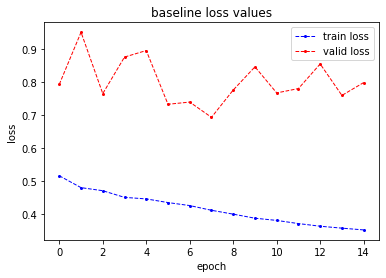

<Figure size 432x288 with 0 Axes>

In [21]:
model = rnn_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model'
rt, rv=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

plt.figure()
plt.title('baseline loss values')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rt, 'bo--', label = 'train loss', linewidth=1, markersize=2)
plt.plot(rv, 'ro--', label = 'valid loss', linewidth=1, markersize=2)
plt.legend(loc='upper right')
plt.show()
plt.clf()


# 4.3.4 Empirical study

Different RNN settings, define model1, model2, model3

In [12]:
class rnn1_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn1_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.GRU(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [13]:
class rnn2_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn2_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [14]:
class rnn3_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn3_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional = True)
        self.linear = nn.Linear(n_hidden*2,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

Train model1, store best acc checkpoint and get loss values

In [22]:
model = rnn1_model(len(txt_field.vocab), 50,64,2,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model1'
rt1, rv1=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.4686, Val Loss: 0.6182, Val Acc: 0.6807, Time Cost: 0.94s
Model saved to rnn_model1
Epoch [2/15], Train Loss: 0.3592, Val Loss: 0.6113, Val Acc: 0.7080, Time Cost: 0.89s
Model saved to rnn_model1
Epoch [3/15], Train Loss: 0.2903, Val Loss: 0.5949, Val Acc: 0.7349, Time Cost: 0.88s
Model saved to rnn_model1
Epoch [4/15], Train Loss: 0.2315, Val Loss: 0.5457, Val Acc: 0.7788, Time Cost: 0.86s
Model saved to rnn_model1
Epoch [5/15], Train Loss: 0.1938, Val Loss: 0.6767, Val Acc: 0.7524, Time Cost: 0.85s
Epoch [6/15], Train Loss: 0.1501, Val Loss: 0.6537, Val Acc: 0.7754, Time Cost: 0.85s
Epoch [7/15], Train Loss: 0.1163, Val Loss: 0.6013, Val Acc: 0.8037, Time Cost: 0.85s
Model saved to rnn_model1
Epoch [8/15], Train Loss: 0.0864, Val Loss: 0.7972, Val Acc: 0.7705, Time Cost: 0.85s
Epoch [9/15], Train Loss: 0.0641, Val Loss: 0.8031, Val Acc: 0.8110, Time Cost: 0.85s
Model saved to rnn_model1
Epoch [10/15], Train Loss: 0.0394, Val Loss: 0.8800, Val Acc: 0.7988, 

Train model2, store best acc checkpoint and get loss values

In [23]:
model = rnn2_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model2'
rt2, rv2=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.4931, Val Loss: 0.7440, Val Acc: 0.5630, Time Cost: 0.73s
Model saved to rnn_model2
Epoch [2/15], Train Loss: 0.3838, Val Loss: 0.5720, Val Acc: 0.7188, Time Cost: 0.72s
Model saved to rnn_model2
Epoch [3/15], Train Loss: 0.3140, Val Loss: 0.5609, Val Acc: 0.7471, Time Cost: 0.68s
Model saved to rnn_model2
Epoch [4/15], Train Loss: 0.2627, Val Loss: 0.4893, Val Acc: 0.7759, Time Cost: 0.65s
Model saved to rnn_model2
Epoch [5/15], Train Loss: 0.2161, Val Loss: 0.6404, Val Acc: 0.7441, Time Cost: 0.66s
Epoch [6/15], Train Loss: 0.1804, Val Loss: 0.5741, Val Acc: 0.7715, Time Cost: 0.73s
Epoch [7/15], Train Loss: 0.1406, Val Loss: 0.6140, Val Acc: 0.7744, Time Cost: 0.67s
Epoch [8/15], Train Loss: 0.1073, Val Loss: 0.7554, Val Acc: 0.7637, Time Cost: 0.66s
Epoch [9/15], Train Loss: 0.0801, Val Loss: 0.9138, Val Acc: 0.7515, Time Cost: 0.66s
Epoch [10/15], Train Loss: 0.0617, Val Loss: 0.7688, Val Acc: 0.7861, Time Cost: 0.65s
Model saved to rnn_model2
Epoch [11

Train model3, store best acc checkpoint and get loss values

In [24]:
model = rnn3_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model3'
rt3, rv3=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.4994, Val Loss: 0.7441, Val Acc: 0.5493, Time Cost: 0.94s
Model saved to rnn_model3
Epoch [2/15], Train Loss: 0.3876, Val Loss: 0.5938, Val Acc: 0.7227, Time Cost: 0.90s
Model saved to rnn_model3
Epoch [3/15], Train Loss: 0.3118, Val Loss: 0.6398, Val Acc: 0.7168, Time Cost: 0.85s
Epoch [4/15], Train Loss: 0.2597, Val Loss: 0.5808, Val Acc: 0.7451, Time Cost: 0.85s
Model saved to rnn_model3
Epoch [5/15], Train Loss: 0.2176, Val Loss: 0.5673, Val Acc: 0.7695, Time Cost: 0.85s
Model saved to rnn_model3
Epoch [6/15], Train Loss: 0.1732, Val Loss: 0.6467, Val Acc: 0.7686, Time Cost: 0.84s
Epoch [7/15], Train Loss: 0.1352, Val Loss: 0.6448, Val Acc: 0.7783, Time Cost: 0.84s
Model saved to rnn_model3
Epoch [8/15], Train Loss: 0.1081, Val Loss: 0.6327, Val Acc: 0.7896, Time Cost: 0.86s
Model saved to rnn_model3
Epoch [9/15], Train Loss: 0.0807, Val Loss: 0.7955, Val Acc: 0.7812, Time Cost: 0.85s
Epoch [10/15], Train Loss: 0.0586, Val Loss: 0.8539, Val Acc: 0.7759, 

Do Q5

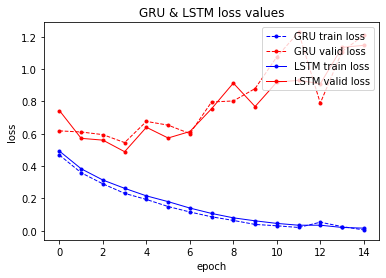

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure()
plt.title('GRU & LSTM loss values')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rt1, 'bo--', label = 'GRU train loss', linewidth=1, markersize=3)
plt.plot(rv1, 'ro--', label = 'GRU valid loss', linewidth=1, markersize=3)
plt.plot(rt2, 'bo-', label = 'LSTM train loss', linewidth=1, markersize=3)
plt.plot(rv2, 'ro-', label = 'LSTM valid loss', linewidth=1, markersize=3)
plt.legend(loc='upper right')
plt.show()
plt.clf()

Do Q6

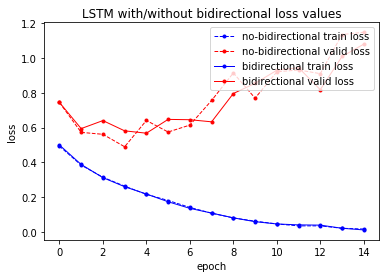

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure()
plt.title('LSTM with/without bidirectional loss values')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rt2, 'bo--', label = 'no-bidirectional train loss', linewidth=1, markersize=3)
plt.plot(rv2, 'ro--', label = 'no-bidirectional valid loss', linewidth=1, markersize=3)
plt.plot(rt3, 'bo-', label = 'bidirectional train loss', linewidth=1, markersize=3)
plt.plot(rv3, 'ro-', label = 'bidirectional valid loss', linewidth=1, markersize=3)
plt.legend(loc='upper right')
plt.show()
plt.clf()

# 4.3.5 Improving Model Training

## A. Pre-trained Word Embedding

Firstly, report the L2 distance for Q7a

In [31]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=50)
# get l2 distance
print(torch.norm(glove['happy']-glove['good']))
print(torch.norm(glove['france']-glove['germany']))
print(torch.norm(glove['france']-glove['happy']))

tensor(2.7146)
tensor(3.9774)
tensor(6.3060)


Define model4, model5, model6

In [27]:
class rnn4_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn4_model, self).__init__()
        self.embedding_glove = GloVe(name='6B', dim=50)
        print(self.embedding_glove)
        self.emb = nn.Embedding.from_pretrained(embeddings=self.embedding_glove.vectors, freeze=True)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [28]:
class rnn5_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn5_model, self).__init__()
        self.embedding_glove = GloVe(name='6B', dim=50)
        print(self.embedding_glove)
        self.emb = nn.Embedding.from_pretrained(embeddings=self.embedding_glove.vectors, freeze=False)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [29]:
class rnn6_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn6_model, self).__init__()
        
        self.rand_vec = torch.randn((400000, 50))
        self.emb = nn.Embedding.from_pretrained(embeddings=self.rand_vec, freeze=True)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=False)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

Train model4, model5 and model6

In [32]:
txt_field.build_vocab(train, min_freq=2, vectors='glove.6B.50d')
model = rnn4_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model4'
rt4, rv4=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.5116, Val Loss: 0.8944, Val Acc: 0.4941, Time Cost: 0.69s
Model saved to rnn_model4
Epoch [2/15], Train Loss: 0.4912, Val Loss: 0.8159, Val Acc: 0.4941, Time Cost: 0.62s
Epoch [3/15], Train Loss: 0.4839, Val Loss: 0.8852, Val Acc: 0.4941, Time Cost: 0.61s
Epoch [4/15], Train Loss: 0.4539, Val Loss: 0.7205, Val Acc: 0.5933, Time Cost: 0.61s
Model saved to rnn_model4
Epoch [5/15], Train Loss: 0.4346, Val Loss: 0.7493, Val Acc: 0.6118, Time Cost: 0.62s
Model saved to rnn_model4
Epoch [6/15], Train Loss: 0.4036, Val Loss: 0.7756, Val Acc: 0.6255, Time Cost: 0.66s
Model saved to rnn_model4
Epoch [7/15], Train Loss: 0.3898, Val Loss: 0.7718, Val Acc: 0.6362, Time Cost: 0.76s
Model saved to rnn_model4
Epoch [8/15], Train Loss: 0.3605, Val Loss: 0.7628, Val Acc: 0.6304, Time Cost: 0.77s
Epoch [9/15], Train Loss: 0.3431, Val Loss: 0.7193, Val Acc: 0.6396, Time Cost: 0.79s
Model saved to rnn_model4
Epoch [10/15], Train Loss: 0.3294, Val Loss: 0.5677, Val Acc: 0.7026, 

In [33]:
txt_field.build_vocab(train, min_freq=2, vectors='glove.6B.50d')
model = rnn5_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model5'
rt5, rv5=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.5063, Val Loss: 0.8599, Val Acc: 0.4941, Time Cost: 2.85s
Model saved to rnn_model5
Epoch [2/15], Train Loss: 0.3892, Val Loss: 0.6675, Val Acc: 0.6938, Time Cost: 2.76s
Model saved to rnn_model5
Epoch [3/15], Train Loss: 0.2736, Val Loss: 0.5429, Val Acc: 0.7725, Time Cost: 2.72s
Model saved to rnn_model5
Epoch [4/15], Train Loss: 0.1886, Val Loss: 0.6245, Val Acc: 0.7783, Time Cost: 2.72s
Model saved to rnn_model5
Epoch [5/15], Train Loss: 0.1313, Val Loss: 0.4675, Val Acc: 0.8179, Time Cost: 2.81s
Model saved to rnn_model5
Epoch [6/15], Train Loss: 0.0973, Val Loss: 0.6850, Val Acc: 0.7646, Time Cost: 2.79s
Epoch [7/15], Train Loss: 0.0717, Val Loss: 0.8042, Val Acc: 0.7803, Time Cost: 2.78s
Epoch [8/15], Train Loss: 0.0449, Val Loss: 0.8764, Val Acc: 0.7856, Time Cost: 2.72s
Epoch [9/15], Train Loss: 0.0372, Val Loss: 0.9250, Val Acc: 0.7783, Time Cost: 2.72s
Epoch [10/15], Train Loss: 0.0401, Val Loss: 0.8184, Val Acc: 0.7793, Time Cost: 2.72s
Epoch [11

In [34]:
txt_field.build_vocab(train, min_freq=2, vectors='glove.6B.50d')
model = rnn6_model(len(txt_field.vocab), 50,64,1,0.1)
optimizer = Adam(model.parameters())
save_name = 'rnn_model6'
rt6, rv6=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.5250, Val Loss: 0.8210, Val Acc: 0.4941, Time Cost: 0.73s
Model saved to rnn_model6
Epoch [2/15], Train Loss: 0.4835, Val Loss: 0.8069, Val Acc: 0.4971, Time Cost: 0.73s
Model saved to rnn_model6
Epoch [3/15], Train Loss: 0.4764, Val Loss: 0.7740, Val Acc: 0.4971, Time Cost: 0.72s
Epoch [4/15], Train Loss: 0.4721, Val Loss: 0.8134, Val Acc: 0.5063, Time Cost: 0.73s
Model saved to rnn_model6
Epoch [5/15], Train Loss: 0.4627, Val Loss: 0.7952, Val Acc: 0.5083, Time Cost: 0.72s
Model saved to rnn_model6
Epoch [6/15], Train Loss: 0.4592, Val Loss: 0.8155, Val Acc: 0.5107, Time Cost: 0.73s
Model saved to rnn_model6
Epoch [7/15], Train Loss: 0.4571, Val Loss: 0.8331, Val Acc: 0.5093, Time Cost: 0.73s
Epoch [8/15], Train Loss: 0.4498, Val Loss: 0.7774, Val Acc: 0.5117, Time Cost: 0.72s
Model saved to rnn_model6
Epoch [9/15], Train Loss: 0.4454, Val Loss: 0.7933, Val Acc: 0.5137, Time Cost: 0.73s
Model saved to rnn_model6
Epoch [10/15], Train Loss: 0.4398, Val Loss:

Do Q9a

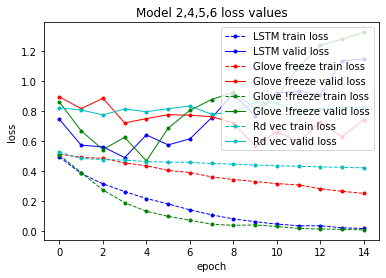

<Figure size 432x288 with 0 Axes>

In [35]:
plt.figure()
plt.title('Model 2,4,5,6 loss values')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rt2, 'bo--', label = 'LSTM train loss', linewidth=1, markersize=3)
plt.plot(rv2, 'bo-', label = 'LSTM valid loss', linewidth=1, markersize=3)
plt.plot(rt4, 'ro--', label = 'Glove freeze train loss', linewidth=1, markersize=3)
plt.plot(rv4, 'ro-', label = 'Glove freeze valid loss', linewidth=1, markersize=3)
plt.plot(rt5, 'go--', label = 'Glove !freeze train loss', linewidth=1, markersize=3)
plt.plot(rv5, 'go-', label = 'Glove !freeze valid loss', linewidth=1, markersize=3)
plt.plot(rt6, 'co--', label = 'Rd vec train loss', linewidth=1, markersize=3)
plt.plot(rv6, 'co-', label = 'Rd vec valid loss', linewidth=1, markersize=3)
plt.legend(loc='upper right')
plt.show()
plt.clf()

## B. Model Weight Initialization

Define two weight-initialize functional

In [36]:
def init_weight1(m):
    for name, p in m.named_parameters():
        if 'bias' in name:
            p.data.fill_(0)
        else:
            nn.init.xavier_normal(p.data)
            
def init_weight2(m):
    for name, p in m.named_parameters():
        if not 'bias' in name:
            nn.init.kaiming_normal(p.data)


Define model7 and model8

In [37]:
class rnn7_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn7_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

In [38]:
class rnn8_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(rnn8_model, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True)
        self.linear = nn.Linear(n_hidden,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sent, sent_len):
        sent_emb = self.emb(sent)
        outputs, hidden = self.rnn(sent_emb)
        #print(outputs.shape)
        out = self.sigmoid(self.linear(outputs))
        return out

Train model7 and model8

In [39]:
model = rnn7_model(len(txt_field.vocab), 50,64,1,0.1)
model.apply(init_weight1)
txt_field.build_vocab(train, min_freq=2)
optimizer = Adam(model.parameters())
save_name = 'rnn_model7'
rt7, rv7=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  
C:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

Epoch [1/15], Train Loss: 0.4555, Val Loss: 0.5750, Val Acc: 0.6924, Time Cost: 0.71s
Model saved to rnn_model7
Epoch [2/15], Train Loss: 0.2528, Val Loss: 0.5128, Val Acc: 0.7852, Time Cost: 0.69s
Model saved to rnn_model7
Epoch [3/15], Train Loss: 0.1384, Val Loss: 0.5521, Val Acc: 0.7983, Time Cost: 0.77s
Model saved to rnn_model7
Epoch [4/15], Train Loss: 0.0911, Val Loss: 0.7368, Val Acc: 0.7837, Time Cost: 0.71s
Epoch [5/15], Train Loss: 0.0538, Val Loss: 0.7528, Val Acc: 0.7998, Time Cost: 0.67s
Model saved to rnn_model7
Epoch [6/15], Train Loss: 0.0356, Val Loss: 1.0674, Val Acc: 0.7852, Time Cost: 0.67s
Epoch [7/15], Train Loss: 0.0366, Val Loss: 1.0939, Val Acc: 0.7495, Time Cost: 0.67s
Epoch [8/15], Train Loss: 0.0266, Val Loss: 1.0637, Val Acc: 0.7798, Time Cost: 0.67s
Epoch [9/15], Train Loss: 0.0171, Val Loss: 1.4768, Val Acc: 0.7646, Time Cost: 0.68s
Epoch [10/15], Train Loss: 0.0174, Val Loss: 1.2102, Val Acc: 0.7837, Time Cost: 0.67s
Epoch [11/15], Train Loss: 0.0111, 

In [40]:
model = rnn8_model(len(txt_field.vocab), 50,64,1,0.1)
model.apply(init_weight2)
txt_field.build_vocab(train, min_freq=2)
optimizer = Adam(model.parameters())
save_name = 'rnn_model8'
rt8, rv8=TRAIN(model=model, train_loader=train_iter, valid_loader=valid_iter,
      num_epochs=n_epochs, criterion=criterion, optimizer=optimizer,
      val_acc=val_acc, device=device, save_name=save_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/15], Train Loss: 0.4511, Val Loss: 0.7263, Val Acc: 0.6450, Time Cost: 0.74s
Model saved to rnn_model8
Epoch [2/15], Train Loss: 0.2981, Val Loss: 0.5438, Val Acc: 0.7637, Time Cost: 0.69s
Model saved to rnn_model8
Epoch [3/15], Train Loss: 0.1944, Val Loss: 0.6160, Val Acc: 0.7441, Time Cost: 0.68s
Epoch [4/15], Train Loss: 0.1225, Val Loss: 0.6097, Val Acc: 0.7852, Time Cost: 0.67s
Model saved to rnn_model8
Epoch [5/15], Train Loss: 0.0878, Val Loss: 0.6115, Val Acc: 0.7974, Time Cost: 0.67s
Model saved to rnn_model8
Epoch [6/15], Train Loss: 0.0517, Val Loss: 0.7900, Val Acc: 0.7949, Time Cost: 0.69s
Epoch [7/15], Train Loss: 0.0290, Val Loss: 0.9238, Val Acc: 0.7935, Time Cost: 0.67s
Epoch [8/15], Train Loss: 0.0155, Val Loss: 1.1595, Val Acc: 0.7808, Time Cost: 0.71s
Epoch [9/15], Train Loss: 0.0113, Val Loss: 1.1666, Val Acc: 0.7837, Time Cost: 0.68s
Epoch [10/15], Train Loss: 0.0096, Val Loss: 1.3472, Val Acc: 0.7891, Time Cost: 0.70s
Epoch [11/15], Train Loss: 0.0074, 

Do Q8b

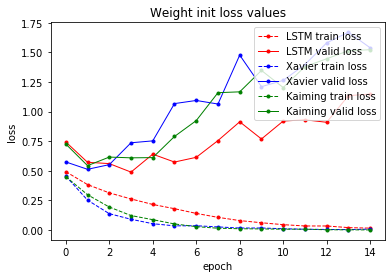

<Figure size 432x288 with 0 Axes>

In [41]:
plt.figure()
plt.title('Weight init loss values')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rt2, 'ro--', label = 'LSTM train loss', linewidth=1, markersize=3)
plt.plot(rv2, 'ro-', label = 'LSTM valid loss', linewidth=1, markersize=3)
plt.plot(rt7, 'bo--', label = 'Xavier train loss', linewidth=1, markersize=3)
plt.plot(rv7, 'bo-', label = 'Xavier valid loss', linewidth=1, markersize=3)
plt.plot(rt8, 'go--', label = 'Kaiming train loss', linewidth=1, markersize=3)
plt.plot(rv8, 'go-', label = 'Kaiming valid loss', linewidth=1, markersize=3)
plt.legend(loc='upper right')
plt.show()
plt.clf()

In [66]:
model = rnn7_model(len(txt_field.vocab), 50,64,1,0.1)
model.apply(init_weight1)
model.to(device)
optimizer = Adam(model.parameters())
save_name='rnn_model7'
load_checkpoint(save_name, model, optimizer)
test_pred = []
test_iter = BucketIterator(test, batch_size = 1, device = 'cuda', train = False, sort = False)
#valid_iter = BucketIterator(valid, batch_size = 1, device = 'cuda', train = False, sort = False)
for i, text_info in enumerate(test_iter):
    labels = np.array(text_info.label.cpu())
    sent, sent_len = text_info.text
    sent = sent.to(device)
    sent_len = sent_len.to(device)
    outputs = model(sent, sent_len)
    outputs = outputs[:,-1]
    pred = torch.tensor(outputs).view(1,-1)
    pred = np.array(pred.cpu()).ravel()
    print('lb={}, pred={}'.format(labels[0],pred[0]))
    test_pred.append(pred[0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Model loaded from rnn_model7, with val loss: 0.5212021232582629, and val acc: 0.81591796875
lb=2, pred=0.004483646713197231
lb=2, pred=0.08506250381469727
lb=2, pred=0.9811691641807556
lb=2, pred=0.005217095371335745
lb=2, pred=0.3651954233646393
lb=2, pred=0.1124771386384964
lb=2, pred=0.8545140624046326
lb=2, pred=0.018344830721616745
lb=2, pred=0.9751124978065491
lb=2, pred=0.1054777055978775
lb=2, pred=0.8498209118843079
lb=2, pred=0.021871229633688927
lb=2, pred=0.0018319966038689017
lb=2, pred=0.000985837308689952
lb=2, pred=0.24889136850833893
lb=2, pred=0.004068438895046711
lb=2, pred=0.05691499263048172
lb=2, pred=0.9663177132606506
lb=2, pred=0.0022162010427564383
lb=2, pred=0.005574062932282686
lb=2, pred=0.971842348575592
lb=2, pred=0.0032424742821604013
lb=2, pred=0.05680910125374794
lb=2, pred=0.981777548789978
lb=2, pred=0.8367921113967896
lb=2, pred=0.5602620244026184
lb=2, pred=0.010605915449559689
lb=2, pred=0.10320064425468445
lb=2, pred=0.006942963693290949
lb=2, pr

lb=2, pred=0.9259507060050964
lb=2, pred=0.002926275599747896
lb=2, pred=0.000943439023103565
lb=2, pred=0.004617738071829081
lb=2, pred=0.25003939867019653
lb=2, pred=0.9744481444358826
lb=2, pred=0.028027310967445374
lb=2, pred=0.0008961333078332245
lb=2, pred=0.0024397969245910645
lb=2, pred=0.028928890824317932
lb=2, pred=0.9375889897346497
lb=2, pred=0.970270574092865
lb=2, pred=0.10234923660755157
lb=2, pred=0.007048523984849453
lb=2, pred=0.0037093653809279203
lb=2, pred=0.0019415339920669794
lb=2, pred=0.004937706980854273
lb=2, pred=0.011472403071820736
lb=2, pred=0.055171020328998566
lb=2, pred=0.003164534689858556
lb=2, pred=0.8069021701812744
lb=2, pred=0.9747791290283203
lb=2, pred=0.6557708978652954
lb=2, pred=0.9593247175216675
lb=2, pred=0.8616869449615479
lb=2, pred=0.0023856949992477894
lb=2, pred=0.9805899858474731
lb=2, pred=0.15929564833641052
lb=2, pred=0.0012824818259105086
lb=2, pred=0.0017129495972767472
lb=2, pred=0.9669103622436523
lb=2, pred=0.00122319068759

lb=2, pred=0.8878493309020996
lb=2, pred=0.0010258235270157456
lb=2, pred=0.8461009860038757
lb=2, pred=0.965039849281311
lb=2, pred=0.0019965521059930325
lb=2, pred=0.7797238826751709
lb=2, pred=0.09109563380479813
lb=2, pred=0.24721306562423706
lb=2, pred=0.9234219789505005
lb=2, pred=0.9843863844871521
lb=2, pred=0.5185415148735046
lb=2, pred=0.0014657546998932958
lb=2, pred=0.02966141514480114
lb=2, pred=0.16157333552837372
lb=2, pred=0.980970561504364
lb=2, pred=0.9880997538566589
lb=2, pred=0.8109033107757568
lb=2, pred=0.7678270936012268
lb=2, pred=0.004053477663546801
lb=2, pred=0.0015730573795735836
lb=2, pred=0.14575830101966858
lb=2, pred=0.9813061356544495
lb=2, pred=0.9794909358024597
lb=2, pred=0.8904508352279663
lb=2, pred=0.7728298306465149
lb=2, pred=0.009319394826889038
lb=2, pred=0.003901958465576172
lb=2, pred=0.0021926944609731436
lb=2, pred=0.9839422106742859
lb=2, pred=0.18680089712142944
lb=2, pred=0.004202910698950291
lb=2, pred=0.11992382258176804
lb=2, pred=0

lb=2, pred=0.23302292823791504
lb=2, pred=0.9671086072921753
lb=2, pred=0.47744253277778625
lb=2, pred=0.9715697169303894
lb=2, pred=0.0017515701474621892
lb=2, pred=0.01563969999551773
lb=2, pred=0.5020002126693726
lb=2, pred=0.31655630469322205
lb=2, pred=0.8315086960792542
lb=2, pred=0.00694147078320384
lb=2, pred=0.9607644081115723
lb=2, pred=0.7896775603294373
lb=2, pred=0.4646778106689453
lb=2, pred=0.852798581123352
lb=2, pred=0.11412627249956131
lb=2, pred=0.0015211834106594324
lb=2, pred=0.15953387320041656
lb=2, pred=0.00047833804273977876
lb=2, pred=0.06841985881328583
lb=2, pred=0.04370866343379021
lb=2, pred=0.01216241717338562
lb=2, pred=0.08954676240682602
lb=2, pred=0.0012253415770828724
lb=2, pred=0.0009145282092504203
lb=2, pred=0.00683876546099782
lb=2, pred=0.7828824520111084
lb=2, pred=0.27815160155296326
lb=2, pred=0.7872923016548157
lb=2, pred=0.059960540384054184
lb=2, pred=0.9487263560295105
lb=2, pred=0.8086327910423279
lb=2, pred=0.9864418506622314
lb=2, pred

lb=2, pred=0.025847937911748886
lb=2, pred=0.30563926696777344
lb=2, pred=0.9630512595176697
lb=2, pred=0.21727484464645386
lb=2, pred=0.7391029000282288
lb=2, pred=0.06783495098352432
lb=2, pred=0.051138803362846375
lb=2, pred=0.03713815659284592
lb=2, pred=0.0009310924797318876
lb=2, pred=0.8260390162467957
lb=2, pred=0.9702103137969971
lb=2, pred=0.40050822496414185
lb=2, pred=0.019152356311678886
lb=2, pred=0.015691515058279037
lb=2, pred=0.6737069487571716
lb=2, pred=0.40840810537338257
lb=2, pred=0.9512487649917603
lb=2, pred=0.0009772200137376785
lb=2, pred=0.0010368895018473268
lb=2, pred=0.9154042601585388
lb=2, pred=0.36742010712623596
lb=2, pred=0.04185527563095093
lb=2, pred=0.2719257175922394
lb=2, pred=0.021343931555747986
lb=2, pred=0.2007630318403244
lb=2, pred=0.08859880268573761
lb=2, pred=0.9721212387084961
lb=2, pred=0.5479508638381958
lb=2, pred=0.0019999186042696238
lb=2, pred=0.9058353900909424
lb=2, pred=0.0037472625263035297
lb=2, pred=0.15756209194660187
lb=2,

lb=2, pred=0.9142304062843323
lb=2, pred=0.009270838461816311
lb=2, pred=0.08402983844280243
lb=2, pred=0.0010871663689613342
lb=2, pred=0.5981010794639587
lb=2, pred=0.9505314230918884
lb=2, pred=0.008559973910450935
lb=2, pred=0.0019003547495231032
lb=2, pred=0.07257411628961563
lb=2, pred=0.5854201912879944
lb=2, pred=0.009104142896831036
lb=2, pred=0.9015819430351257
lb=2, pred=0.0009152888669632375
lb=2, pred=0.037961773574352264
lb=2, pred=0.973442554473877
lb=2, pred=0.00028313411166891456
lb=2, pred=0.02301161363720894
lb=2, pred=0.0012738348450511694
lb=2, pred=0.9481266140937805
lb=2, pred=0.04097505658864975
lb=2, pred=0.9860363006591797
lb=2, pred=0.7227694392204285
lb=2, pred=0.9833720326423645
lb=2, pred=0.008409915491938591
lb=2, pred=0.44803088903427124
lb=2, pred=0.9846750497817993
lb=2, pred=0.9876430034637451
lb=2, pred=0.0009029046050272882
lb=2, pred=0.9831783175468445
lb=2, pred=0.0001479384518461302
lb=2, pred=0.0020718241576105356
lb=2, pred=0.017298158258199692

lb=2, pred=0.5532059669494629
lb=2, pred=0.05702967569231987
lb=2, pred=0.9508301615715027
lb=2, pred=0.02261386625468731
lb=2, pred=0.003197137266397476
lb=2, pred=0.013394405134022236
lb=2, pred=0.23912450671195984
lb=2, pred=0.8935081362724304
lb=2, pred=0.5578963756561279
lb=2, pred=0.8290112614631653
lb=2, pred=0.0656232237815857
lb=2, pred=0.2708861827850342
lb=2, pred=0.0004303345049265772
lb=2, pred=0.0028195169288665056
lb=2, pred=0.24946072697639465
lb=2, pred=0.3789551854133606
lb=2, pred=0.9890109896659851
lb=2, pred=0.9461482167243958
lb=2, pred=0.0007259998819790781
lb=2, pred=0.004655865952372551
lb=2, pred=0.02232220023870468
lb=2, pred=0.008498725481331348
lb=2, pred=0.011220907792448997
lb=2, pred=0.7275106906890869
lb=2, pred=0.18379895389080048
lb=2, pred=0.34216785430908203
lb=2, pred=0.0005488458555191755
lb=2, pred=0.04716336354613304
lb=2, pred=0.00031232478795573115
lb=2, pred=0.9902015328407288
lb=2, pred=0.031183499842882156
lb=2, pred=0.5817965269088745
lb=2

lb=2, pred=0.007912972010672092
lb=2, pred=0.3572646975517273
lb=2, pred=0.8589981198310852
lb=2, pred=0.00044317878200672567
lb=2, pred=0.9259825944900513
lb=2, pred=0.9656458497047424
lb=2, pred=0.6394676566123962
lb=2, pred=0.004936059471219778
lb=2, pred=0.9738258719444275
lb=2, pred=0.0016387796495109797


# 4.3.6 Prediction

In [73]:
test_df = pd.read_csv(PATH+'test.csv', sep=',')
for i in range(len(test_pred)):
    if test_pred[i] > 0.5:
        test_df['label'][i]=1
    else:
        test_df['label'][i]=0
test_df.to_csv(PATH+'pred.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [74]:
test_df.to_csv(PATH+'pred.csv', index=False)